# Pyspark TensorFlow Inference

## Image classification
Based on: https://www.tensorflow.org/tutorials/keras/save_and_load

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import tensorflow as tf
import os

from tensorflow import keras

print(tf.version.VERSION)

2024-09-24 23:15:02.904030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 23:15:02.920909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 23:15:02.926050: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 23:15:02.938741: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 23:15:03.625886: W tensorflow/comp

2.17.0


In [2]:
# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### Load and preprocess dataset

In [3]:
# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28 * 28) / 255.0
test_images = test_images[:1000].reshape(-1, 28 * 28) / 255.0

train_images.shape, test_images.shape

((1000, 784), (1000, 784))

### Define a model

In [5]:
# Define a simple sequential model
def create_model():
    model = tf.keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

/rishic/anaconda3/envs/spark-dl-tf/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-24 23:15:08.061986: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29951 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB-H, pci bus id: 0000:34:00.0, compute capability: 7.0
2024-09-24 23:15:08.063390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30827 MB memory:  -> device: 1, name: Tesla V100-SXM3-32GB-H, pci bus id: 0000:36:00.0, compute capability: 7.0
2024-09-24 23:15:08.064700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replic

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### Save checkpoints during training

In [6]:
checkpoint_path = "training_1/checkpoint.model.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_sparse_categorical_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(train_images, 
          train_labels,  
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/10


I0000 00:00:1727219709.296350 1199547 service.cc:146] XLA service 0x7fa444048540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727219709.296373 1199547 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
I0000 00:00:1727219709.296376 1199547 service.cc:154]   StreamExecutor device (1): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
I0000 00:00:1727219709.296378 1199547 service.cc:154]   StreamExecutor device (2): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
I0000 00:00:1727219709.296381 1199547 service.cc:154]   StreamExecutor device (3): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
I0000 00:00:1727219709.296383 1199547 service.cc:154]   StreamExecutor device (4): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
I0000 00:00:1727219709.296385 1199547 service.cc:154]   StreamExecutor device (5): Tesla V100-SXM3-32GB-H, Compute Capability 7.0
I0000 00:00:1727219709.296388 1199547 service.cc:15

 1/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 2.3282 - sparse_categorical_accuracy: 0.1250

I0000 00:00:1727219710.156745 1199547 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.5763 - sparse_categorical_accuracy: 0.5285
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.79700, saving model to training_1/checkpoint.model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 1.5630 - sparse_categorical_accuracy: 0.5330 - val_loss: 0.6973 - val_sparse_categorical_accuracy: 0.7970
Epoch 2/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.2844 - sparse_categorical_accuracy: 0.9688
Epoch 2: val_sparse_categorical_accuracy improved from 0.79700 to 0.83400, saving model to training_1/checkpoint.model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3970 - sparse_categorical_accuracy: 0.8921 - val_loss: 0.5249 - val_sparse_categorical_accuracy: 0.8340
Epoch 3/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.2555 - sparse_categorical_accuracy: 0.9375
Epoch 3: val_sparse_categorical_accuracy improved from 0.83400 to 0.84500, saving model to training_1/checkpoint.model.keras
32/32 ━━━━━━━━━━━━━━

In [7]:
os.listdir(checkpoint_dir)

['checkpoint.model.keras']

In [8]:
# Export model in saved_model format
model.export("mnist_model")

INFO:tensorflow:Assets written to: mnist_model/assets


INFO:tensorflow:Assets written to: mnist_model/assets


Saved artifact at 'mnist_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140369058297616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140369057351824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140369057351632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140369057351440: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [9]:
# Create a basic model instance
model = create_model()

# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

/rishic/anaconda3/envs/spark-dl-tf/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 - 1s - 21ms/step - loss: 2.3017 - sparse_categorical_accuracy: 0.1240
Untrained model, accuracy: 12.40%


In [10]:
# Load the weights from the checkpoint
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 0s - 2ms/step - loss: 0.4012 - sparse_categorical_accuracy: 0.8750
Restored model, accuracy: 87.50%


/rishic/anaconda3/envs/spark-dl-tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Checkpoint callback options

In [11]:
!rm -rf training_2
!mkdir training_2

In [12]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_2/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Calculate the number of batches per epoch
import math
n_batches = len(train_images) / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*n_batches)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_images, 
          train_labels,
          epochs=50, 
          batch_size=batch_size, 
          callbacks=[cp_callback],
          validation_data=(test_images, test_labels),
          verbose=0)


Epoch 5: saving model to training_2/cp-0005.weights.h5

Epoch 10: saving model to training_2/cp-0010.weights.h5

Epoch 15: saving model to training_2/cp-0015.weights.h5

Epoch 20: saving model to training_2/cp-0020.weights.h5

Epoch 25: saving model to training_2/cp-0025.weights.h5

Epoch 30: saving model to training_2/cp-0030.weights.h5

Epoch 35: saving model to training_2/cp-0035.weights.h5

Epoch 40: saving model to training_2/cp-0040.weights.h5

Epoch 45: saving model to training_2/cp-0045.weights.h5

Epoch 50: saving model to training_2/cp-0050.weights.h5


In [13]:
os.listdir(checkpoint_dir)

['cp-0000.weights.h5',
 'cp-0010.weights.h5',
 'cp-0050.weights.h5',
 'cp-0005.weights.h5',
 'cp-0025.weights.h5',
 'cp-0020.weights.h5',
 'cp-0045.weights.h5',
 'cp-0040.weights.h5',
 'cp-0015.weights.h5',
 'cp-0035.weights.h5',
 'cp-0030.weights.h5']

In [14]:
latest = "training_2/cp-0030.weights.h5"

In [15]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model from the latest checkpoint
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 1s - 21ms/step - loss: 0.4431 - sparse_categorical_accuracy: 0.8740
Restored model, accuracy: 87.40%


## PySpark

In [16]:
import pandas as pd
from pyspark.sql import SparkSession

In [17]:
num_threads = 6

# Creating a local Spark session for demonstration, in case it hasn't already been created.

_config = {
    "spark.master": f"local[{num_threads}]",
    "spark.driver.host": "127.0.0.1",
    "spark.task.maxFailures": "1",
    "spark.driver.memory": "8g",
    "spark.executor.memory": "8g",
    "spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled": "false",
    "spark.sql.pyspark.jvmStacktrace.enabled": "true",
    "spark.sql.execution.arrow.pyspark.enabled": "true",
    "spark.python.worker.reuse": "true",
}
spark = SparkSession.builder.appName("spark-dl-example")
for key, value in _config.items():
    spark = spark.config(key, value)
spark = spark.getOrCreate()

sc = spark.sparkContext

24/09/24 23:15:29 WARN Utils: Your hostname, dgx2h0194.spark.sjc4.nvmetal.net resolves to a loopback address: 127.0.1.1; using 10.150.30.2 instead (on interface enp134s0f0np0)
24/09/24 23:15:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/24 23:15:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Convert numpy array to Spark DataFrame (via Pandas DataFrame)

In [18]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images)
test_pdf.shape

(1000, 784)

In [19]:
%%time
df = spark.createDataFrame(test_pdf)

CPU times: user 332 ms, sys: 62.9 ms, total: 395 ms
Wall time: 2.64 s


### Save as Parquet (784 columns of float)

In [20]:
%%time
df.write.mode("overwrite").parquet("mnist_784")

24/09/24 23:15:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/09/24 23:15:35 WARN TaskSetManager: Stage 0 contains a task of very large size (1050 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 13.3 ms, sys: 8.7 ms, total: 22 ms
Wall time: 2.34 s


### Save as Parquet (1 column of 784 float)

In [21]:
%%time
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

CPU times: user 21.8 ms, sys: 8.92 ms, total: 30.7 ms
Wall time: 30 ms


(1000, 1)

In [22]:
%%time
df = spark.createDataFrame(pdf)

CPU times: user 102 ms, sys: 12.5 ms, total: 114 ms
Wall time: 205 ms


In [23]:
%%time
df.write.mode("overwrite").parquet("mnist_1")

24/09/24 23:15:36 WARN TaskSetManager: Stage 1 contains a task of very large size (1054 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 392 μs, sys: 4.24 ms, total: 4.64 ms
Wall time: 342 ms


### Check arrow memory configuration

In [24]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty" 

## Inference using Spark DL API

### 1 column of 784 float

In [25]:
import numpy as np
import os
import pandas as pd

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import array, col, struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [26]:
# get absolute path to model
model_dir = "{}/training_1/checkpoint.model.keras".format(os.getcwd())

In [27]:
def predict_batch_fn():
    import tensorflow as tf

    # Enable GPU memory growth to avoid CUDA OOM
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    model = tf.keras.models.load_model(model_dir)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)
        
    return predict

In [28]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=1024,
                          input_tensor_shapes=[[784]])

In [29]:
df = spark.read.parquet("mnist_1")
len(df.columns)

1

In [30]:
df.show(5)

+--------------------+
|                data|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 5 rows



In [31]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

2024-09-24 23:15:39.866276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 23:15:39.884227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 23:15:39.889583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 23:15:39.902715: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 23:15:39.910360: E external/local_

CPU times: user 154 ms, sys: 87.7 ms, total: 241 ms
Wall time: 27.2 s


In [32]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step+ 6) / 6]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step 4) / 6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


CPU times: user 58.3 ms, sys: 19 ms, total: 77.3 ms
Wall time: 1.12 s


In [33]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


CPU times: user 41.8 ms, sys: 14.9 ms, total: 56.7 ms
Wall time: 923 ms


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step 6) / 6]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


#### Check predictions

In [34]:
preds = df.withColumn("preds", mnist(*df.columns)).limit(10).toPandas()
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6.3137636, -3.2166262, -1.3338214, 12.582729..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.1267514, -7.2566614, 1.5177205, -3.2577438..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.2369697, 0.9145107, 0.07408107, 0.91041464..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.390323, -7.0785513, 11.627161, 0.6066802, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.9732468, 3.9353404, -0.911746, -1.0734574,..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.512949, -3.8078513, 1.7254832, 3.7201457, ..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.8460994, 4.401718, 0.45493424, -0.7537605,..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.131109, -1.4874746, -5.5806513, 0.6310075,..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.09935758, -2.5780919, -1.2520716, -5.499449..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.6970993, -1.5710942, -4.6353655, 1.0403421..."


In [35]:
sample = preds.iloc[0]
sample.preds

array([-6.3137636, -3.2166262, -1.3338214, 12.582729 , -5.863056 ,
        2.559228 , -7.5267835, -0.8944007, -1.9424003, -4.330171 ],
      dtype=float32)

In [36]:
import matplotlib.pyplot as plt
import numpy as np

In [37]:
prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

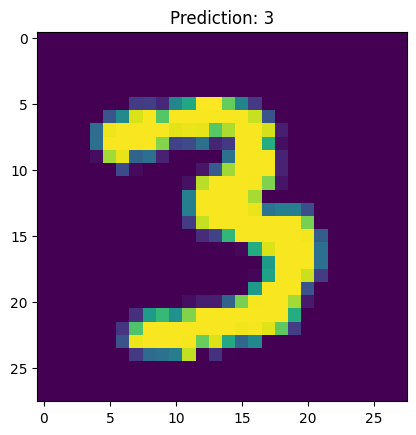

In [38]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

### 784 columns of float

In [39]:
import numpy as np

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import array, col, struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [40]:
def predict_batch_fn():
    import tensorflow as tf
    # Enable GPU memory growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
            
    model = tf.keras.models.load_model(model_dir)
    def predict(inputs: np.ndarray) -> np.ndarray:
        return model.predict(inputs)
        
    return predict

In [41]:
mnist = predict_batch_udf(predict_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=1024,
                          input_tensor_shapes=[[784]])

In [42]:
df = spark.read.parquet("mnist_784")
len(df.columns)

784

In [43]:
%%time
preds = df.withColumn("preds", mnist(struct(*df.columns))).collect()

2024-09-24 23:16:11.576128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 23:16:11.593901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 23:16:11.598996: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 23:16:11.611744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 23:16:11.613989: E external/local_

CPU times: user 206 ms, sys: 136 ms, total: 342 ms
Wall time: 32.3 s


In [44]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step 6) / 6]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step 5) / 6]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   4) / 6]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


CPU times: user 120 ms, sys: 48.3 ms, total: 168 ms
Wall time: 2.17 s


In [45]:
# should raise ValueError
# preds = df.withColumn("preds", mnist(*df.columns)).collect()

### Check prediction

In [46]:
preds = df.withColumn("preds", mnist(struct(df.columns))).limit(10).toPandas()
preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step 5) / 6]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,preds
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-6.3137636, -3.2166264, -1.333822, 12.582729,..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-3.126751, -7.2566624, 1.5177205, -3.2577438,..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-3.2369695, 0.91451085, 0.07408092, 0.9104143..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-3.390323, -7.0785513, 11.627161, 0.60668, -4..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-3.9732468, 3.9353406, -0.911746, -1.0734576,..."
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-5.5129485, -3.8078513, 1.7254835, 3.7201447,..."
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-3.8460996, 4.401718, 0.45493427, -0.75376046..."
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-2.131109, -1.4874747, -5.580651, 0.63100755,..."
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.09935761, -2.5780919, -1.2520716, -5.499449..."
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-1.6970996, -1.571094, -4.6353655, 1.0403421,..."


In [47]:
import matplotlib.pyplot as plt
import numpy as np

In [48]:
sample = preds.iloc[0]
sample.preds

array([-6.3137636 , -3.2166264 , -1.333822  , 12.582729  , -5.863056  ,
        2.5592272 , -7.5267835 , -0.89440125, -1.9424002 , -4.330171  ],
      dtype=float32)

In [49]:
prediction = np.argmax(sample.preds)
img = sample.drop('preds').to_numpy(dtype=float)
img = np.array(img).reshape(28,28)

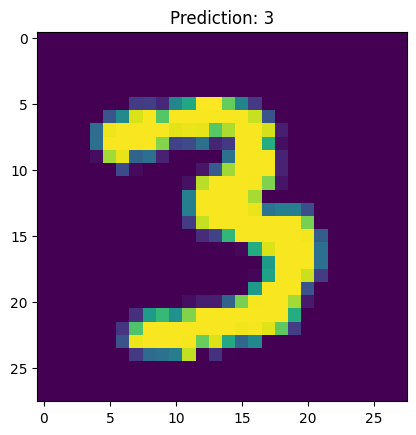

In [50]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

### Using Triton Inference Server

Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [51]:
import os
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import col, struct
from pyspark.sql.types import ArrayType, FloatType

In [52]:
%%bash
# copy model to expected layout for Triton
rm -rf models
mkdir -p models/mnist_model/1
cp -r mnist_model models/mnist_model/1/model.savedmodel

# add config.pbtxt
cp models_config/mnist_model/config.pbtxt models/mnist_model/config.pbtxt

#### Start Triton Server on each executor

In [53]:
num_executors = 1
triton_models_dir = "{}/models".format(os.getcwd())
nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:24.08-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="64M",
            volumes={triton_models_dir: {"bind": "/models", "mode": "ro"}}
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.barrier().mapPartitions(start_triton).collect()

>>>> starting triton: b0d515aa67a8                                  (0 + 1) / 1]


[True]

In [54]:
df = spark.read.parquet("mnist_1")
df.schema

StructType([StructField('data', ArrayType(DoubleType(), True), True)])

#### Run inference

In [55]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient

    np_types = {
      "BOOL": np.dtype(np.bool_),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)

    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))

        response = client.infer(model_name, inputs=request)

        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)

    return predict

In [56]:
from functools import partial

predict = predict_batch_udf(partial(triton_fn, "localhost:8001", "mnist_model"),
                            return_type=ArrayType(FloatType()),
                            input_tensor_shapes=[[784]],
                            batch_size=8192)

In [57]:
%%time
preds = df.withColumn("preds", predict(struct("data"))).collect()

CPU times: user 41.7 ms, sys: 0 ns, total: 41.7 ms
Wall time: 1.06 s


In [58]:
%%time
preds = df.withColumn("preds", predict("data")).collect()

CPU times: user 42.4 ms, sys: 19.8 ms, total: 62.2 ms
Wall time: 354 ms


In [59]:
%%time
preds = df.withColumn("preds", predict(col("data"))).limit(10).toPandas()
preds

CPU times: user 10.2 ms, sys: 6.97 ms, total: 17.1 ms
Wall time: 226 ms


,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.9187374, -3.77601, -2.5133493, 13.121505, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.9349496, -7.515232, 1.0022008, -4.4591513,..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.5180511, 0.64477426, -0.117591076, 0.44328..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.7138467, -7.6691647, 11.831367, -0.0725396..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-4.017026, 4.285186, -1.3297698, -1.3238704, ..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.2465634, -4.0282125, 1.1952692, 3.5620341,..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.783912, 4.6513677, 0.0007356042, -1.058918..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.6537862, -1.5823168, -6.69336, -0.19124416..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.86291754, -3.0844328, -1.9796382, -6.566232..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.4750699, -1.7143235, -5.506122, 0.57001084..."


In [60]:
import matplotlib.pyplot as plt
import numpy as np

In [61]:
sample = preds.iloc[0]
sample.preds

prediction = np.argmax(sample.preds)
img = np.array(sample.data).reshape(28,28)

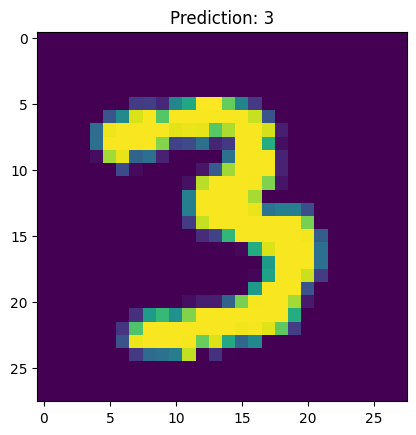

In [62]:
plt.figure()
plt.title("Prediction: {}".format(prediction))
plt.imshow(img)
plt.show()

#### Stop Triton Server on each executor

In [63]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.barrier().mapPartitions(stop_triton).collect()

>>>> stopping containers: ['b0d515aa67a8']


[True]

In [64]:
spark.stop()